In [1]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import numpy
import observations.dimensions.one.sampling as observe
import matplotlib.pyplot as plt

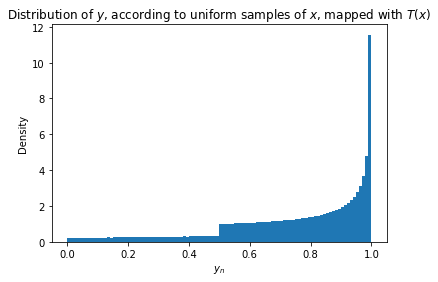

In [3]:
plt.hist(numpy.transpose(observe.sample(0))[0], bins = 100, density = True)
plt.title("Distribution of $y$, according to uniform samples of $x$, mapped with $T(x)$")
plt.xlabel("$y_n$")
plt.ylabel("Density")
plt.show()

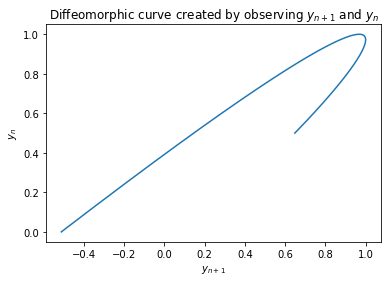

In [4]:
ys = observe.sample(1)

#plt.scatter(numpy.transpose(ys)[0], numpy.transpose(ys)[1], s = 0.5)
plt.plot(numpy.transpose(ys)[1], numpy.transpose(ys)[0])
plt.title("Diffeomorphic curve created by observing $y_{n+1}$ and $y_{n}$")
plt.xlabel('$y_{n+1}$')
plt.ylabel('$y_{n}$')
plt.show()

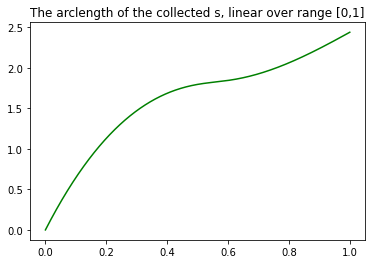

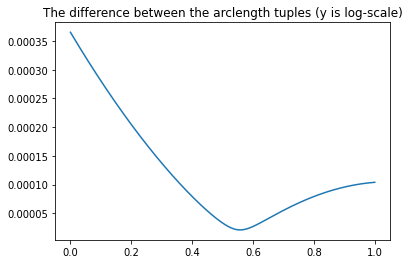

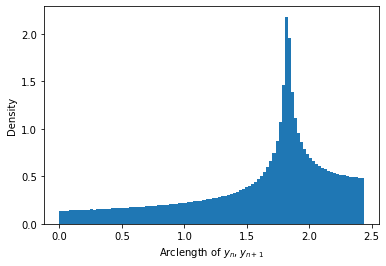

In [5]:
from observations.utils import arclen, lags

plt.title("The arclength of the collected s, linear over range [0,1]")
plt.plot(numpy.linspace(0, 1, observe.samplesize)[1:], arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]]), label = "$i = 1$, $y_{n}, y_{n+1}$", color = "green")
plt.show()

training_tuples = list(zip(*lags(arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]]), 1)))
real_difference = [abs(t0 - t1) for t0, t1 in training_tuples]

plt.title("The difference between the arclength tuples (y is log-scale)") # TODO it  is not log scaled as of now
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], real_difference)
#plt.yscale("log")
plt.show()

s = arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]])
plt.hist(s, bins=100, density=True)
plt.xlabel("Arclength of $y_{n}, y_{n+1}$")
plt.ylabel("Density")
plt.show()

[Epoch:   1] training loss: 0.000165496  validation loss: 0.000000015
[Epoch:   2] training loss: 0.000000009  validation loss: 0.000000397
[Epoch:   3] training loss: 0.000000034  validation loss: 0.000000006
[Epoch:   4] training loss: 0.000000033  validation loss: 0.000000049
[Epoch:   5] training loss: 0.000000032  validation loss: 0.000000007
[Epoch:   6] training loss: 0.000000033  validation loss: 0.000000302
[Epoch:   7] training loss: 0.000000034  validation loss: 0.000000022
[Epoch:   8] training loss: 0.000000032  validation loss: 0.000000092
[Epoch:   9] training loss: 0.000000032  validation loss: 0.000000007


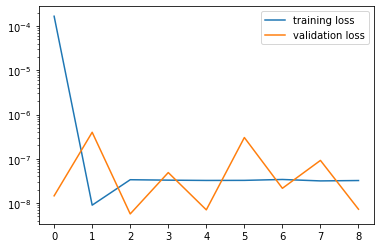

In [16]:
import dynamics.nets as nets
import dynamics.utils
import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler()
training_tuples_normalized = [(x[0], x[1]) for x in normalizer.fit_transform(training_tuples)]

model = nets.RK4N(input_size = 1, num_param=1, hidden_size=20, h=1, num_hidden_layers=3)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
train_loader, val_loader = dynamics.utils.training_validator_splitter(training_tuples_normalized, bs=3)

# Losses
train_losses = []
val_losses = []

for epoch in range(1, 10):  # loop over the dataset multiple times
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = torch.unsqueeze(inputs, 1).float()
        labels = torch.unsqueeze(labels, 1).float()

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # For statistics
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    val_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs = torch.unsqueeze(inputs, 1).float()
            labels = torch.unsqueeze(labels, 1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print('[Epoch: %3d] training loss: %.9f  validation loss: %.9f' %
            (epoch, train_loss,val_loss))

plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.yscale("log")
plt.legend()
plt.show()

[0.00035741 0.00035751 0.00035737 ... 0.00014543 0.00014548 0.00014552]


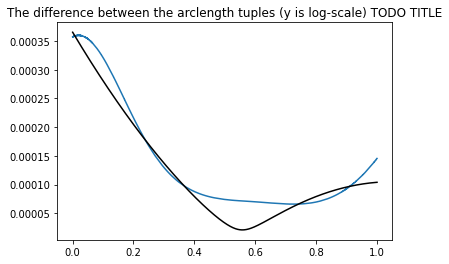

In [17]:
def s_n1(s_n):
    return model(torch.tensor([[s_n]]).float()).item()

def s_n1_tensor(s_n):
    return model(s_n.float())

fitted_values_normalized = s_n1_tensor(torch.unsqueeze(torch.tensor(numpy.transpose(training_tuples_normalized)[0]), 1))
#print(normalizer.inverse_transform(fitted_values.detach().numpy()))
training_tuples_fitted_normalized = torch.cat((torch.unsqueeze(torch.tensor(numpy.transpose(training_tuples_normalized)[0]), 1), fitted_values_normalized), 1).detach().numpy()
training_tuples_fitted = normalizer.inverse_transform(training_tuples_fitted_normalized)
#training_tuples_fitted = [(sn, s_n1(sn)) for (sn, _) in training_tuples]

difference = numpy.abs(training_tuples_fitted[:, 0] - training_tuples_fitted[:, 1])
print(difference)

plt.title("The difference between the arclength tuples (y is log-scale) TODO TITLE")
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], difference)
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], real_difference, color='black')
#plt.yscale("log")
plt.show()

#print(training_tuples)
#print(s_n1(1.716607903670211))

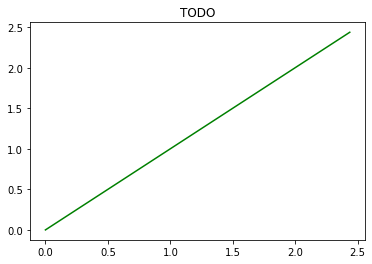

In [18]:
plt.title("TODO") # TODO: write title
plt.plot(numpy.linspace(0, s[-1], 1000), [s_n1(x) for x in numpy.linspace(0, s[-1], 1000)], label = "$i = 1$, $y_{n}, y_{n+1}$", color = "green")
plt.show()

In [19]:
from scipy.integrate import solve_ivp

def f(t, y):
    return model.one_step(torch.FloatTensor([y])).detach().numpy()[0]
sol = solve_ivp(f, [0, s[-1]], [0])

print(sol.y)

[[ 0.00000000e+00 -3.50773335e-09 -3.85850668e-08 -3.89391872e-07
  -3.89648980e-06 -2.60969381e-05 -8.54604334e-05]]
